In [14]:
import pandas as pd
from ml_utils import *
import matplotlib.pyplot as plt

## Load data

In [15]:
def load_data(path):
    data = pd.read_csv(path)
    x = data['reviewText'].tolist()
    y = data['sentiment'].tolist()
    return x, y

In [16]:
train_x, train_y = load_data('train.csv')
test_x, test_y = load_data('test.csv')

In [17]:
train_y_label = np.array([1 if y == 'pos' else 0 for y in train_y])
test_y_label = np.array([1 if y == 'pos' else 0 for y in test_y])

In [18]:
print('training size:', len(train_x))
print('test size:', len(test_x))

training size: 25000
test size: 25000


## Preprocessing

In [19]:
import nltk
import string

In [20]:
word_to_index, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

In [21]:
stopwords = list(pd.read_csv("stopwordsmodify.txt", header=None).values.reshape(-1))

In [22]:
lemmatizer = nltk.WordNetLemmatizer()
transtbl = str.maketrans(string.punctuation, ' ' * len(string.punctuation))

In [23]:
contractions = np.load("contractions.npy").item()

In [24]:
def preprocessing(line):
    line = line.replace('<br />', '')   # Remove html tag (<br />)
    
    for t in line.split():              # open the contractions
        if t in contractions:
            line = line.replace(t, contractions[t])
            
    line = line.translate(transtbl)     # Remove punctuation
    
    # Get tokens
    tokens = []
    for t in nltk.word_tokenize(line):
        t = t.lower()
        try:
            word_to_index[t]
        except:
            continue
            
        if t not in stopwords:
            lemma = lemmatizer.lemmatize(t, 'v')
            tokens.append(lemma)
            
    return ' '.join(tokens)

In [25]:
preprocessing('For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni character is an absolute scream. Watch for Alan "The Skipper" Hale jr. as a police Sgt.')

'movie get no respect sure lot memorable quote list gem imagine movie joe piscopo actually funny maureen stapleton scene stealer moroni character absolute scream watch alan skipper hale jr police sgt'

In [26]:
train_x = list(map(preprocessing, train_x))
test_x = list(map(preprocessing, test_x))

In [27]:
train_x = np.array(train_x)
test_x = np.array(test_x)

In [28]:
train_x[0]

'movie get no respect sure lot memorable quote list gem imagine movie joe piscopo actually funny maureen stapleton scene stealer moroni character absolute scream watch alan skipper hale jr police sgt'

## Embedding

In [29]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation

Using TensorFlow backend.


In [30]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Embedding, Conv1D, MaxPooling1D
from keras.preprocessing import sequence
from keras import regularizers

np.random.seed(1)

In [31]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Build and return a Keras Embedding Layer given word_to_vec mapping and word_to_index mapping
    
    Args:
        word_to_vec_map (dict[str->np.ndarray]): map from a word to a vector with shape (N,) where N is the length of a word vector (50 in our case)
        word_to_index (dict[str->int]): map from a word to its index in vocabulary

    Return:
        Keras.layers.Embedding: Embedding layer
    """
    
    # Keras requires vocab length start from index 1
    vocab_len = len(word_to_index) + 1  
    emb_dim = list(word_to_vec_map.values())[0].shape[0]
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    return Embedding(
        input_dim=vocab_len, 
        output_dim=emb_dim, 
        trainable=False,  # Indicating this is a pre-trained embedding 
        weights=[emb_matrix])

In [32]:
maxlen = len(max(train_x, key=len).split())
print(maxlen)

1437


## Model

In [33]:
def movie_model(input_shape, word_to_vec_map, word_to_index):
    
    # Input layer
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Step 2: Embedding layer
    # Embedding layer
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices) 
    
    
    X = LSTM(128, return_sequences=True, recurrent_dropout=0.5)(embeddings)  # N->N RNN
    X = Dropout(0.5)(X)
    X = LSTM(128, recurrent_dropout=0.5)(X)  # N -> 1 RNN
    X = Dropout(0.5)(X)
    X = Dense(1, activation='sigmoid')(X)

    model = Model(inputs=sentence_indices, outputs=X)
    
    
    return model

In [34]:
def movie_model2(input_shape, word_to_vec_map, word_to_index):
    

    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Step 2: Embedding layer
    # Embedding layer
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices) 


    X = LSTM(128, recurrent_dropout=0.6)(embeddings)  # N -> 1 RNN
    X = Dropout(0.4)(X)
    X = Dense(1, activation='sigmoid')(X)

    model = Model(inputs=sentence_indices, outputs=X)
    
    # ------------------
    # End of your code
    
    return model

In [35]:
def sentences_to_indices_revise(X, word_to_index, max_len):
    """
    Return a array of indices of a given sentence. The sentence will be trimed/padded to max_len

    Args:
        X (np.ndarray): Input array of sentences, the shape is (m,) where m is the number of sentences, each sentence is a str. Example X: array(['Sentence 1', 'Setence 2'])
        word_to_index (dict[str->int]): map from a word to its index in vocabulary

    Return:
        indices (np.ndarray): the shape is (m, max_len) where m is the number of sentences
    """
    m = X.shape[0]
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):
        sentence_words = X[i].lower().split()
        
        j = 0
        for w in sentence_words:
            try:
                X_indices[i, j] = word_to_index[w]
                j = j + 1
            except:
                j = j + 1
                continue
                
    return X_indices

In [36]:
X_train_indices = sentences_to_indices_revise(train_x, word_to_index, maxlen)
X_test_indices = sentences_to_indices_revise(test_x, word_to_index, maxlen)

In [37]:
x_train = sequence.pad_sequences(X_train_indices, maxlen=120, truncating='post')
x_test = sequence.pad_sequences(X_test_indices, maxlen=120, truncating='post')
x_train.shape

(25000, 120)

In [38]:
model = movie_model((120,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 120, 50)           20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 120, 128)          91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total para

In [39]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
X_tmp = np.array(["I love rollick is a good guy"])
sentences_to_indices_revise(X_tmp, word_to_index, max_len = 20)

array([[185457., 226278.,      0., 192973.,  43010., 164328., 169725.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.]])

## Training

In [41]:
history = model.fit(
    x_train, 
    train_y_label, 
    epochs = 30, 
    batch_size = 30, 
    shuffle=True)

Epoch 1/30
25000/25000 [==============================] - 140s 6ms/step - loss: 0.6771 - acc: 0.5693
Epoch 2/30
25000/25000 [==============================] - 139s 6ms/step - loss: 0.6729 - acc: 0.5857
Epoch 3/30
25000/25000 [==============================] - 139s 6ms/step - loss: 0.6743 - acc: 0.5706
Epoch 4/30
25000/25000 [==============================] - 138s 6ms/step - loss: 0.5168 - acc: 0.7542
Epoch 5/30
25000/25000 [==============================] - 138s 6ms/step - loss: 0.4588 - acc: 0.7919
Epoch 6/30
25000/25000 [==============================] - 138s 6ms/step - loss: 0.4434 - acc: 0.8010
Epoch 7/30
25000/25000 [==============================] - 138s 6ms/step - loss: 0.4335 - acc: 0.8062
Epoch 8/30
25000/25000 [==============================] - 138s 6ms/step - loss: 0.4271 - acc: 0.8087
Epoch 9/30
25000/25000 [==============================] - 143s 6ms/step - loss: 0.4182 - acc: 0.8148
Epoch 10/30
25000/25000 [==============================] - 141s 6ms/step - loss: 0.4133 - a

In [44]:
history2 = model.fit(
    x_train, 
    train_y_label, 
    epochs = 10, 
    batch_size = 30, 
    shuffle=True)

Epoch 1/10
25000/25000 [==============================] - 139s 6ms/step - loss: 0.2695 - acc: 0.8920
Epoch 2/10
25000/25000 [==============================] - 140s 6ms/step - loss: 0.2639 - acc: 0.8934
Epoch 3/10
25000/25000 [==============================] - 140s 6ms/step - loss: 0.2655 - acc: 0.8962
Epoch 4/10
25000/25000 [==============================] - 140s 6ms/step - loss: 0.2477 - acc: 0.9018
Epoch 5/10
25000/25000 [==============================] - 140s 6ms/step - loss: 0.2500 - acc: 0.9018
Epoch 6/10
25000/25000 [==============================] - 147s 6ms/step - loss: 0.2449 - acc: 0.9040
Epoch 7/10
25000/25000 [==============================] - 143s 6ms/step - loss: 0.2376 - acc: 0.9071
Epoch 8/10
25000/25000 [==============================] - 138s 6ms/step - loss: 0.2325 - acc: 0.9097
Epoch 9/10
25000/25000 [==============================] - 141s 6ms/step - loss: 0.2293 - acc: 0.9127
Epoch 10/10
25000/25000 [==============================] - 146s 6ms/step - loss: 0.2269 - a

In [45]:
loss, acc = model.evaluate(x_test, test_y_label)
print('loss = %.4f, acc = %.2f%%' % (loss, acc * 100))

25000/25000 [==============================] - 33s 1ms/step
loss = 0.3721, acc = 85.04%


In [46]:
loss, acc = model.evaluate(x_train, train_y_label)
print('loss = %.4f, acc = %.2f%%' % (loss, acc * 100))

25000/25000 [==============================] - 32s 1ms/step
loss = 0.1550, acc = 94.68%


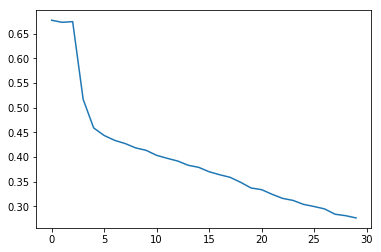

In [47]:
plt.plot(history.history['loss'])

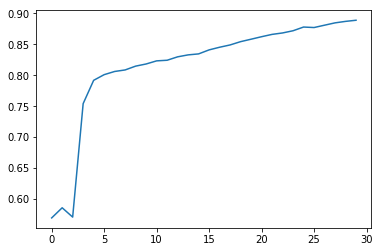

In [48]:
plt.plot(history.history['acc'])

In [345]:
# save model
with open("L2_P120_E30_COV_model.json", "w") as fp:
    fp.write(model.to_json())

In [346]:
# Save model weights
model.save_weights("L2_P120_E30_COV_model.h5")

In [50]:
from keras.models import model_from_json

# Load model structure
with open("L2_P120_E30_model.json", "r") as fp:
    model_best = model_from_json(fp.read())

# Load model weights
model_best.load_weights("L2_P120_E30_model.h5")

In [52]:
model_best.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
loss, acc = model_best.evaluate(x_test, test_y_label)
print('loss = %.4f, acc = %.2f%%' % (loss, acc * 100))

25000/25000 [==============================] - 34s 1ms/step
loss = 0.3644, acc = 86.45%


In [54]:
loss, acc = model_best.evaluate(x_train, train_y_label)
print('loss = %.4f, acc = %.2f%%' % (loss, acc * 100))

25000/25000 [==============================] - 33s 1ms/step
loss = 0.2182, acc = 92.48%


In [73]:
x_test = np.array(["a good movie"])
X_test_indices = sentences_to_indices(x_test, word_to_index, 120)
print(x_test[0], model.predict(X_test_indices))

a good movie [[0.97509956]]
